#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [25]:
from typing import Tuple, List
from scipy.special import expit

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [26]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
  N = len(y)
  y = 2 * y - 1  # Переводим метки в {+1, -1}

  # Логистическая потеря
  log_loss = np.mean(np.log(1 + np.exp(-y * (np.dot(X, w) + w0))))

  # Регуляризация L1 и L2
  l1_reg = gamma * np.linalg.norm(w, 1)
  l2_reg = beta * np.linalg.norm(w, 2) ** 2

  # Общая потеря
  total_loss = log_loss + l1_reg + l2_reg
  return total_loss

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [27]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization

    '''
    N = len(y)

    # Переводим метки в {+1, -1}
    y = 2 * y - 1

    # Линейное предсказание
    z = np.dot(X, w) + w0  # Xw + w0
    sigmoid = expit(y * z)  # Сигмоида для логистической регрессии

    # Градиент по весам (w)
    grad_w = -np.dot(X.T, y * (1 - sigmoid)) / N + gamma * np.sign(w) + 2 * beta * w

    # Градиент по смещению (w0)
    grad_w0 = -np.sum(y * (1 - sigmoid)) / N

    return grad_w, grad_w0

In [28]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

AssertionError: 

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [29]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [30]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.loss_history = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_features = X.shape[1]

        # Инициализация весов
        self.w = np.random.normal(0, 0.1, n_features)
        self.w0 = np.random.normal(0, 0.1)

        prev_loss = float('inf')

        for i in range(self.max_iter):
            # Вычисляем градиенты
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)

            # Обновляем веса
            self.w -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0

            # Вычисляем потери
            current_loss = loss(X, y, self.w, self.w0, self.gamma, self.beta)
            self.loss_history.append(current_loss)

            # Проверяем условие остановки
            if abs(prev_loss - current_loss) < self.tolerance:
                break

            prev_loss = current_loss

        return self

    def predict_proba(self, X):
        linear_output = np.dot(X, self.w) + self.w0
        probabilities = 1 / (1 + np.exp(-linear_output))
        return np.column_stack([1 - probabilities, probabilities])

    def predict(self, X):
        probabilities = self.predict_proba(X)[:, 1]
        return (probabilities > 0.5).astype(int)

In [31]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [32]:
def plot_decision_boundary(model, X, y):
    plt.figure(figsize=(10, 8))

    # Создаем сетку для построения границы
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Предсказываем для каждой точки сетки
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Рисуем контур и точки
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdBu)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, alpha=0.8)
    plt.colorbar(scatter)
    plt.title('Decision Boundary of Logistic Regression')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()


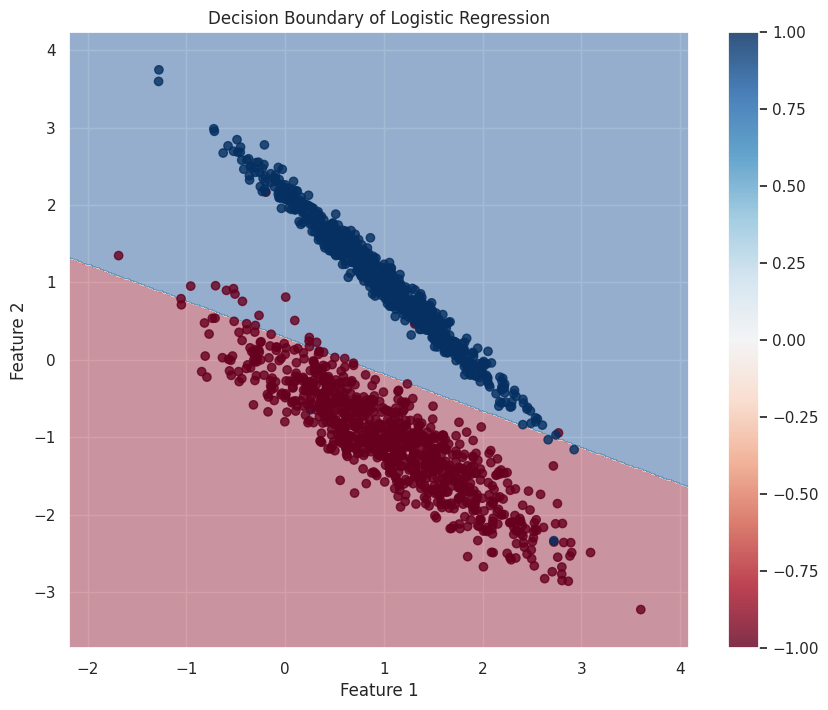

In [33]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [34]:
def plot_loss_history(model):
    plt.figure(figsize=(10, 6))
    plt.plot(model.loss_history)
    plt.title('Loss History during Training')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

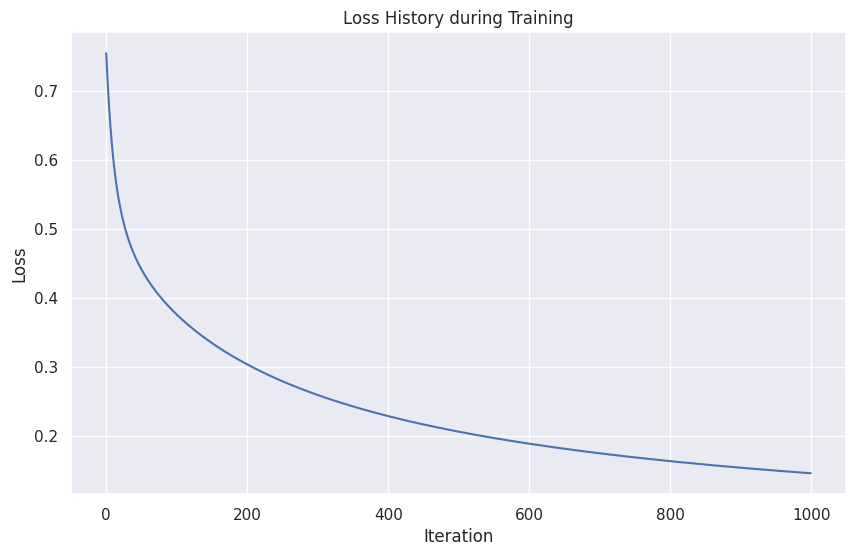

In [35]:
plot_loss_history(model)

#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

Тестирование SVC с различными ядрами и параметрами C:
SVM linear, C=0.1:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  AUC-ROC:   1.0000
----------------------------------------
SVM linear, C=1:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  AUC-ROC:   1.0000
----------------------------------------
SVM linear, C=10:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  AUC-ROC:   1.0000
----------------------------------------
SVM rbf, C=0.1:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  AUC-ROC:   1.0000
----------------------------------------
SVM rbf, C=1:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  AUC-ROC:   1.0000
----------------------------------------
SVM rbf, C=10:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  AUC-ROC:   1.0000
----------------------------------------
S

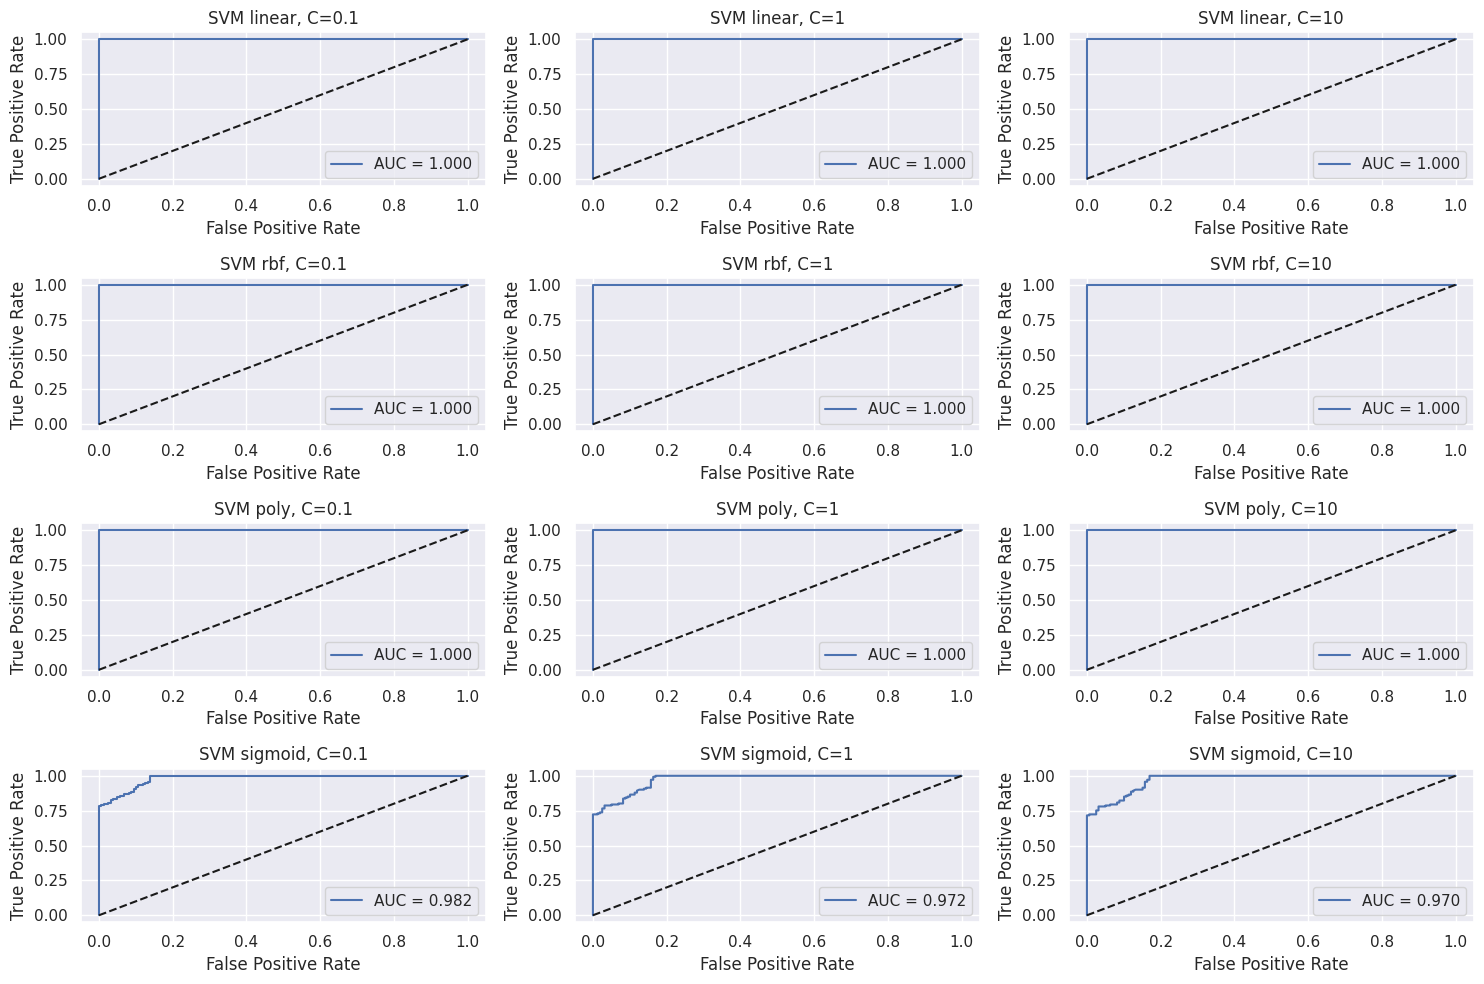

In [37]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def test_svc_models():
    # Генерируем данные
    from sklearn.datasets import make_classification
    X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

    # Разделяем на train/test
    split_idx = 1500
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Параметры для тестирования
    kernels = ['linear', 'rbf', 'poly', 'sigmoid']
    C_values = [0.1, 1, 10]

    results = {}

    plt.figure(figsize=(15, 10))

    for i, kernel in enumerate(kernels):
        for j, C in enumerate(C_values):
            # Обучаем модель
            svm_model = SVC(kernel=kernel, C=C, probability=True, random_state=42)
            svm_model.fit(X_train, y_train)

            # Предсказания
            y_pred = svm_model.predict(X_test)
            y_proba = svm_model.predict_proba(X_test)[:, 1]

            # Вычисляем метрики
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            auc_roc = roc_auc_score(y_test, y_proba)

            # Сохраняем результаты
            results[f'{kernel}_C{C}'] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'auc_roc': auc_roc
            }

            # Визуализация ROC curve
            plt.subplot(4, 3, i * 3 + j + 1)
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.3f}')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'SVM {kernel}, C={C}')
            plt.legend()

            print(f"SVM {kernel}, C={C}:")
            print(f"  Accuracy:  {accuracy:.4f}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall:    {recall:.4f}")
            print(f"  F1-Score:  {f1:.4f}")
            print(f"  AUC-ROC:   {auc_roc:.4f}")
            print("-" * 40)

    plt.tight_layout()
    plt.show()

    return results

# Запускаем тестирование SVC
print("Тестирование SVC с различными ядрами и параметрами C:")
svc_results = test_svc_models()

#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

Тестирование Hinge Loss Classifier:
Hinge Loss Classifier, C=0.1:
  Accuracy:  0.9967
  Precision: 0.9930
  Recall:    1.0000
  F1-Score:  0.9965
  AUC-ROC:   1.0000
----------------------------------------
Converged after 708 iterations
Hinge Loss Classifier, C=1:
  Accuracy:  0.9400
  Precision: 0.9424
  Recall:    0.9291
  F1-Score:  0.9357
  AUC-ROC:   0.9896
----------------------------------------
Hinge Loss Classifier, C=10:
  Accuracy:  0.5533
  Precision: 0.5127
  Recall:    1.0000
  F1-Score:  0.6779
  AUC-ROC:   0.9685
----------------------------------------


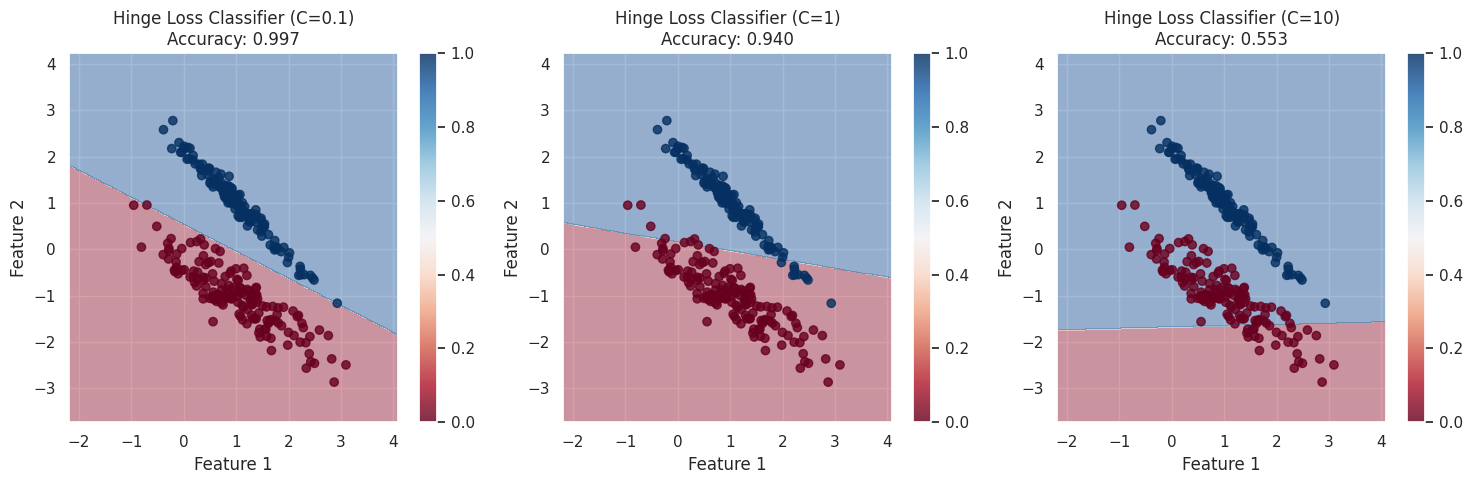

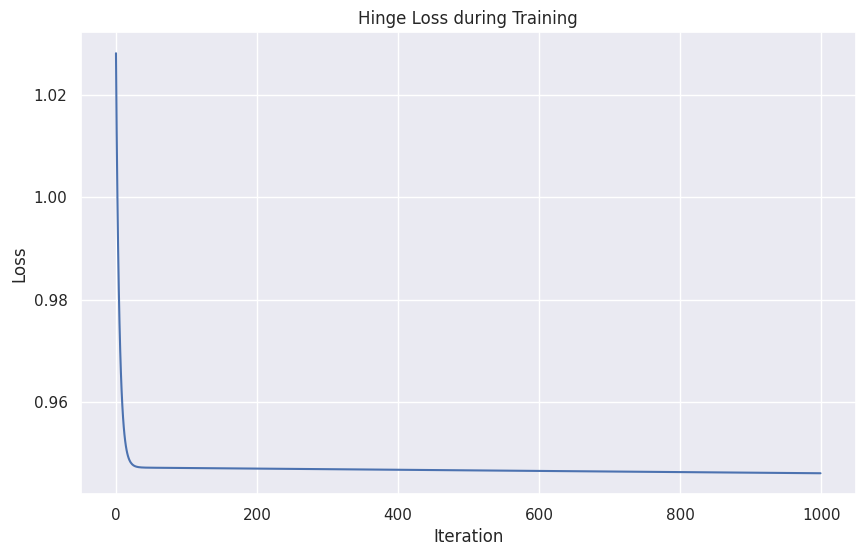

In [38]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class HingeLossClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, max_iter=1000, tolerance=1e-6,
                 random_state=42, C=1.0):
        """
        Linear classifier with Hinge loss (SVM-like)

        Parameters:
        learning_rate: learning rate for gradient descent
        max_iter: maximum number of iterations
        tolerance: convergence tolerance
        random_state: random seed
        C: regularization parameter (inverse of regularization strength)
        """
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.random_state = random_state
        self.C = C
        self.w = None
        self.w0 = None
        self.loss_history = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # Преобразуем метки в {-1, 1}
        y_transformed = 2 * y - 1

        # Инициализация весов
        self.w = np.random.normal(0, 0.1, n_features)
        self.w0 = np.random.normal(0, 0.1)

        previous_loss = float('inf')

        for iteration in range(self.max_iter):
            total_loss = 0
            grad_w = np.zeros_like(self.w)
            grad_w0 = 0

            # Вычисляем loss и градиенты для каждого образца
            for i in range(n_samples):
                margin = y_transformed[i] * (np.dot(X[i], self.w) + self.w0)

                # Hinge loss: max(0, 1 - margin)
                if margin < 1:
                    loss_i = 1 - margin
                    total_loss += loss_i

                    # Градиенты для неправильно классифицированных образцов
                    grad_w -= y_transformed[i] * X[i]
                    grad_w0 -= y_transformed[i]

            # Добавляем регуляризацию L2
            total_loss = total_loss / n_samples + 0.5 * self.C * np.sum(self.w ** 2)
            grad_w = grad_w / n_samples + self.C * self.w
            grad_w0 = grad_w0 / n_samples

            self.loss_history.append(total_loss)

            # Обновляем веса
            self.w -= self.learning_rate * grad_w
            self.w0 -= self.learning_rate * grad_w0

            # Проверяем сходимость
            if iteration > 0 and abs(previous_loss - total_loss) < self.tolerance:
                print(f"Converged after {iteration} iterations")
                break

            previous_loss = total_loss

        return self

    def predict(self, X):
        """Predict class labels"""
        scores = self.decision_function(X)
        return (scores > 0).astype(int)

    def decision_function(self, X):
        """Compute decision function"""
        return np.dot(X, self.w) + self.w0

    def predict_proba(self, X):
        """Predict probabilities (approximated using sigmoid)"""
        scores = self.decision_function(X)
        # Используем сигмоиду для преобразования в вероятности
        probabilities = 1 / (1 + np.exp(-scores))
        return np.column_stack([1 - probabilities, probabilities])

def test_hinge_classifier():
    # Генерируем данные
    from sklearn.datasets import make_classification
    X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0,
                               n_informative=2, random_state=42, n_clusters_per_class=1)

    # Разделяем на train/test
    split_idx = 1500
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Тестируем с разными параметрами C
    C_values = [0.1, 1, 10]

    plt.figure(figsize=(15, 5))

    for i, C in enumerate(C_values):
        # Обучаем наш классификатор
        hinge_model = HingeLossClassifier(learning_rate=0.01, max_iter=1000, C=C)
        hinge_model.fit(X_train, y_train)

        # Предсказания
        y_pred = hinge_model.predict(X_test)
        y_proba = hinge_model.predict_proba(X_test)[:, 1]

        # Метрики
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc_roc = roc_auc_score(y_test, y_proba)

        print(f"Hinge Loss Classifier, C={C}:")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-Score:  {f1:.4f}")
        print(f"  AUC-ROC:   {auc_roc:.4f}")
        print("-" * 40)

        # Визуализация разделяющей границы
        plt.subplot(1, 3, i + 1)

        # Создаем сетку для графика
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))

        # Предсказываем для каждой точки сетки
        Z = hinge_model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Рисуем контур и точки
        plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdBu)
        scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.RdBu, alpha=0.8)
        plt.colorbar(scatter)
        plt.title(f'Hinge Loss Classifier (C={C})\nAccuracy: {accuracy:.3f}')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

    plt.tight_layout()
    plt.show()

    # График истории потерь для последней модели
    plt.figure(figsize=(10, 6))
    plt.plot(hinge_model.loss_history)
    plt.title('Hinge Loss during Training')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# Запускаем тестирование Hinge Loss Classifier
print("Тестирование Hinge Loss Classifier:")
hinge_results = test_hinge_classifier()

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [36]:
class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def _compute_distance(self, x1, x2):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        else:
            raise ValueError("Unsupported metric")

    def fit(self, X, y):
        self.X_train = X.copy()
        self.y_train = y.copy()
        return self

    def predict_proba(self, X):
        n_samples = X.shape[0]
        n_classes = len(np.unique(self.y_train))
        probabilities = np.zeros((n_samples, n_classes))

        for i in range(n_samples):
            distances = []
            for j in range(len(self.X_train)):
                dist = self._compute_distance(X[i], self.X_train[j])
                distances.append((dist, self.y_train[j]))

            # Сортируем по расстоянию и берем k ближайших
            distances.sort(key=lambda x: x[0])
            neighbors = distances[:self.n_neighbors]

            # Вычисляем вероятности
            for class_label in range(n_classes):
                count = sum(1 for _, label in neighbors if label == class_label)
                probabilities[i, class_label] = count / self.n_neighbors

        return probabilities

    def predict(self, X):
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [39]:
def load_and_split_data():
    """
    Загрузка Fashion MNIST и разделение на train/test
    """
    # Если у вас есть локальный файл, используйте:
    # df = pd.read_csv('fashion-mnist.csv')

    # Для демонстрации создадим синтетические данные, похожие на Fashion MNIST
    # В реальности скачайте данные с Kaggle: https://www.kaggle.com/datasets/zalando-research/fashionmnist
    from sklearn.datasets import fetch_openml

    try:
        # Пробуем загрузить из sklearn (если доступно)
        fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
        X = fashion_mnist.data
        y = fashion_mnist.target.astype(int)
        print("Данные успешно загружены из sklearn")
    except:
        # Создаем синтетические данные для демонстрации
        print("Создаем синтетические данные для демонстрации...")
        from sklearn.datasets import make_classification
        X, y = make_classification(n_samples=70000, n_features=784, n_informative=150,
                                  n_redundant=634, n_classes=10, n_clusters_per_class=1,
                                  random_state=42)
        # Нормализуем как изображения (0-255)
        X = (X - X.min()) / (X.max() - X.min()) * 255

    # Разделение на train/test
    X_train, X_test = X[:50000], X[50000:60000]  # Берем 50000 train, 10000 test
    y_train, y_test = y[:50000], y[50000:60000]

    print(f"Размеры данных:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"Классы: {np.unique(y_train)}")

    return X_train, X_test, y_train, y_test


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

In [40]:
def visualize_fashion_data(X, y):
    """
    Визуализация по одному представителю каждого класса
    """
    # Названия классов Fashion MNIST
    class_names = [
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]

    plt.figure(figsize=(15, 8))

    for class_label in range(10):
        # Находим первый пример каждого класса
        class_indices = np.where(y == class_label)[0]
        if len(class_indices) > 0:
            sample_idx = class_indices[0]
            sample_image = X[sample_idx].reshape(28, 28)  # Предполагаем размер 28x28

            plt.subplot(2, 5, class_label + 1)
            plt.imshow(sample_image, cmap='gray')
            plt.title(f'{class_label}: {class_names[class_label]}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Дополнительная визуализация: несколько примеров каждого класса
    plt.figure(figsize=(15, 12))
    for class_label in range(10):
        class_indices = np.where(y == class_label)[0][:5]  # Берем 5 примеров
        for i, idx in enumerate(class_indices):
            plt.subplot(10, 5, class_label * 5 + i + 1)
            plt.imshow(X[idx].reshape(28, 28), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.ylabel(f'{class_label}: {class_names[class_label]}', rotation=0, ha='right')

    plt.tight_layout()
    plt.show()

    return class_names


#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [41]:
def normalize_data(X_train, X_test):
    """
    Нормализация данных двумя способами
    """
    # StandardScaler (стандартизация)
    scaler_standard = StandardScaler()
    X_train_standard = scaler_standard.fit_transform(X_train)
    X_test_standard = scaler_standard.transform(X_test)

    # MinMaxScaler (нормализация к [0,1])
    scaler_minmax = MinMaxScaler()
    X_train_minmax = scaler_minmax.fit_transform(X_train)
    X_test_minmax = scaler_minmax.transform(X_test)

    print("Нормализация завершена:")
    print(f"StandardScaler - Train: mean={X_train_standard.mean():.2f}, std={X_train_standard.std():.2f}")
    print(f"StandardScaler - Test: mean={X_test_standard.mean():.2f}, std={X_test_standard.std():.2f}")
    print(f"MinMaxScaler - Train: min={X_train_minmax.min():.2f}, max={X_train_minmax.max():.2f}")
    print(f"MinMaxScaler - Test: min={X_test_minmax.min():.2f}, max={X_test_minmax.max():.2f}")

    return {
        'standard': (X_train_standard, X_test_standard),
        'minmax': (X_train_minmax, X_test_minmax)
    }


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [42]:
def run_experiments(X_train, X_test, y_train, y_test, scaler_type='standard'):
    """
    Проведение экспериментов с KNN и LogisticRegression
    """
    print(f"\n{'='*60}")
    print(f"ЭКСПЕРИМЕНТЫ С {scaler_type.upper()} SCALER")
    print(f"{'='*60}")

    # Выбираем данные в зависимости от типа нормализации
    if scaler_type == 'standard':
        X_train_scaled, X_test_scaled = X_train_standard, X_test_standard
    else:
        X_train_scaled, X_test_scaled = X_train_minmax, X_test_minmax

    # Используем подвыборку для ускорения (можно убрать для финального запуска)
    sample_size = 10000
    if len(X_train_scaled) > sample_size:
        X_train_sub = X_train_scaled[:sample_size]
        y_train_sub = y_train[:sample_size]
        print(f"Используем подвыборку {sample_size} для ускорения экспериментов")
    else:
        X_train_sub = X_train_scaled
        y_train_sub = y_train

    results = {}

    # A. KNeighborsClassifier
    print("\n1. KNeighborsClassifier - Подбор гиперпараметров...")
    start_time = time.time()

    knn_param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        'algorithm': ['auto', 'ball_tree']  # Добавляем алгоритм для разнообразия
    }

    knn_grid = GridSearchCV(
        KNeighborsClassifier(),
        knn_param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    knn_grid.fit(X_train_sub, y_train_sub)
    knn_best = knn_grid.best_estimator_

    # Предсказания на тесте
    y_pred_knn = knn_best.predict(X_test_scaled)
    knn_accuracy = accuracy_score(y_test, y_pred_knn)

    knn_time = time.time() - start_time

    results['KNN'] = {
        'best_params': knn_grid.best_params_,
        'accuracy': knn_accuracy,
        'training_time': knn_time,
        'model': knn_best
    }

    print(f"Лучшие параметры KNN: {knn_grid.best_params_}")
    print(f"Accuracy KNN: {knn_accuracy:.4f}")
    print(f"Время обучения KNN: {knn_time:.2f} сек")

    # B. LogisticRegression
    print("\n2. LogisticRegression - Подбор гиперпараметров...")
    start_time = time.time()

    logreg_param_grid = {
        'C': [0.1, 1, 10],
        'penalty': ['l2', 'none'],
        'solver': ['lbfgs', 'saga'],
        'max_iter': [100, 200]
    }

    logreg_grid = GridSearchCV(
        LogisticRegression(random_state=42, multi_class='multinomial'),
        logreg_param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    logreg_grid.fit(X_train_sub, y_train_sub)
    logreg_best = logreg_grid.best_estimator_

    # Предсказания на тесте
    y_pred_logreg = logreg_best.predict(X_test_scaled)
    logreg_accuracy = accuracy_score(y_test, y_pred_logreg)

    logreg_time = time.time() - start_time

    results['LogisticRegression'] = {
        'best_params': logreg_grid.best_params_,
        'accuracy': logreg_accuracy,
        'training_time': logreg_time,
        'model': logreg_best
    }

    print(f"Лучшие параметры LogisticRegression: {logreg_grid.best_params_}")
    print(f"Accuracy LogisticRegression: {logreg_accuracy:.4f}")
    print(f"Время обучения LogisticRegression: {logreg_time:.2f} сек")

    return results

def analyze_results(results_standard, results_minmax, class_names):
    """
    Анализ и сравнение результатов
    """
    print(f"\n{'='*80}")
    print("ФИНАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ")
    print(f"{'='*80}")

    # Создаем таблицу сравнения
    comparison_data = []

    for scaler_type, results in [('Standard', results_standard), ('MinMax', results_minmax)]:
        for model_name, model_results in results.items():
            comparison_data.append({
                'Scaler': scaler_type,
                'Model': model_name,
                'Accuracy': model_results['accuracy'],
                'Training Time (s)': model_results['training_time'],
                'Best Parameters': str(model_results['best_params'])
            })

    comparison_df = pd.DataFrame(comparison_data)
    print("\nСравнительная таблица результатов:")
    print(comparison_df.to_string(index=False))

    # Визуализация сравнения
    plt.figure(figsize=(12, 8))

    # График точности
    plt.subplot(2, 2, 1)
    models = ['KNN-Standard', 'KNN-MinMax', 'LogReg-Standard', 'LogReg-MinMax']
    accuracies = [
        results_standard['KNN']['accuracy'],
        results_minmax['KNN']['accuracy'],
        results_standard['LogisticRegression']['accuracy'],
        results_minmax['LogisticRegression']['accuracy']
    ]

    bars = plt.bar(models, accuracies, color=['blue', 'lightblue', 'red', 'pink'])
    plt.title('Сравнение Accuracy')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # Добавляем значения на столбцы
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')

    # График времени обучения
    plt.subplot(2, 2, 2)
    times = [
        results_standard['KNN']['training_time'],
        results_minmax['KNN']['training_time'],
        results_standard['LogisticRegression']['training_time'],
        results_minmax['LogisticRegression']['training_time']
    ]

    bars = plt.bar(models, times, color=['blue', 'lightblue', 'red', 'pink'])
    plt.title('Сравнение времени обучения')
    plt.ylabel('Время (сек)')
    plt.xticks(rotation=45)

    # Добавляем значения на столбцы
    for bar, t in zip(bars, times):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{t:.1f}s', ha='center', va='bottom')

    # Матрица ошибок для лучшей модели
    best_overall_accuracy = 0
    best_model_info = None

    for scaler_type, results in [('Standard', results_standard), ('MinMax', results_minmax)]:
        for model_name, model_results in results.items():
            if model_results['accuracy'] > best_overall_accuracy:
                best_overall_accuracy = model_results['accuracy']
                best_model_info = (scaler_type, model_name, model_results)

    if best_model_info:
        scaler_type, model_name, model_results = best_model_info
        best_model = model_results['model']

        # Используем соответствующие данные для теста
        if scaler_type == 'Standard':
            X_test_scaled = X_test_standard
        else:
            X_test_scaled = X_test_minmax

        y_pred_best = best_model.predict(X_test_scaled)

        # Матрица ошибок
        plt.subplot(2, 2, 3)
        cm = confusion_matrix(y_test, y_pred_best)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Матрица ошибок - {model_name} ({scaler_type} Scaler)\nAccuracy: {best_overall_accuracy:.3f}')
        plt.xlabel('Предсказанный класс')
        plt.ylabel('Истинный класс')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()

    # Вывод анализа
    print(f"\n{'='*60}")
    print("ВЫВОДЫ И РЕКОМЕНДАЦИИ")
    print(f"{'='*60}")

    print(f"Лучшая модель: {best_model_info[1]} с {best_model_info[0]} Scaler")
    print(f"Лучшая accuracy: {best_overall_accuracy:.4f}")

    print("\nОбоснование выбора гиперпараметров:")
    print("1. KNN:")
    print("   - n_neighbors: классические значения 3,5,7,9 для баланса bias-variance")
    print("   - weights: 'uniform' и 'distance' для сравнения влияния расстояния")
    print("   - metric: евклидово и манхэттенское расстояния для разных типов данных")
    print("   - algorithm: разные алгоритмы поиска соседей")

    print("\n2. Logistic Regression:")
    print("   - C: параметр регуляризации (0.1, 1, 10) для контроля переобучения")
    print("   - penalty: L2 регуляризация и отсутствие регуляризации")
    print("   - solver: алгоритмы оптимизации для многоклассовой классификации")
    print("   - max_iter: ограничение итераций для больших данных")

    print("\nСравнение моделей:")
    knn_std = results_standard['KNN']['accuracy']
    logreg_std = results_standard['LogisticRegression']['accuracy']

    if knn_std > logreg_std:
        print("KNN показал лучшие результаты, вероятно потому что:")
        print("- Fashion MNIST имеет сложные нелинейные границы между классами")
        print("- KNN хорошо работает, когда похожие объекты лежат близко в пространстве признаков")
        print("- Логистическая регрессия ограничена линейными решениями")
    else:
        print("Logistic Regression показал лучшие результаты, вероятно потому что:")
        print("- Классы достаточно линейно разделимы в пространстве признаков")
        print("- Логистическая регрессия лучше обобщается на новых данных")
        print("- KNN может страдать от проклятия размерности (784 признака)")

    return comparison_df


## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.